# Data Preprocessing

In [1]:
import pandas as pd

pd.set_option('future.no_silent_downcasting', True)


def get_valid_df(df: pd.DataFrame) -> pd.DataFrame:
    valid_ids = (
        df.groupby("ID")["TrialInfo"]
        .nunique()
        .loc[lambda x: x == 4]  # Only keep IDs with all 4 unique TrialInfo values
        .index
    )

    # Step 2: Filter the original dataframe
    filtered_df = df[df["ID"].isin(valid_ids)]

    df_valid = filtered_df.reset_index(drop=True)
    return df_valid.copy()


def transform_VR_in_long_format(must_catch: bool) -> pd.DataFrame:
    df = pd.read_csv('./data/DrehenFangen.csv')

    # make Date to datetime
    df["Date"] = pd.to_datetime(df["Date"].str.strip(), format="%Y-%m-%d %H:%M:%S")

    # rename the columns
    df.rename(columns={"Success": "Catch", "RotationDegree": "Degree", "Direction": "Turn Direction",
                       "ThrowDegree": "Direction"}, inplace=True)

    date_to_number_map = {
        "2025-02-12": 1,
        "2025-02-13": 1,
        "2025-02-19": 2,
        "2025-02-20": 2,
        "2025-02-26": 3,
        "2025-02-27": 3,
        "2025-03-05": 4,
        "2025-03-06": 4,
    }

    df['DayOnly'] = df['Date'].dt.date
    # replace date with number
    df['TrialInfo'] = df['DayOnly'].astype(str).map(date_to_number_map)

    df["Catch"] = df["Catch"].str.strip().replace({"True": True, "False": False})

    # Filter out where Catch = False
    if must_catch:
        df = df[df["Catch"] == True]

    df = df.sort_values(by=['ID', 'TrialInfo'])

    # keep only the last 5 trials for each ID per Date
    df = df.groupby(['ID', 'TrialInfo']).tail(5)

    df['TrialIndex'] = df.groupby('ID').cumcount() + 1

    # Make Direction and Degree numeric
    df["Degree"] = df["Degree"].str.strip().str.replace(",", ".").astype(float)
    df["Direction"] = df["Direction"].str.strip().str.replace(",", ".").astype(float)
    df["TrialInfo"] = df["TrialInfo"].astype(int)

    df["Turn Direction"] = df["Turn Direction"].str.strip()

    # drop StrenghValue, Source and DayOnly
    df.drop(columns=["Source", "StrenghValue", "DayOnly", "Date"], inplace=True)

    df = df[['ID', 'TrialIndex', 'TrialInfo', 'Catch', "Direction", "Degree", "Turn Direction"]]

    df.reset_index(drop=True, inplace=True)

    def classify_direction(row):
        direction = row["Direction"]
        degree = row["Degree"]

        if direction <= 10:
            return "gerade"
        elif 45 <= degree < 135:
            return "links"
        elif 135 <= degree < 225:
            return "hinten"
        elif 225 <= degree < 315:
            return "rechts"
        else:  # degree between 315–360 or 0–45
            return "vorne"

    df["Direction"] = df.apply(classify_direction, axis=1)

    return df.copy()


def make_long(df: pd.DataFrame, group: str, must_catch: bool) -> pd.DataFrame:
    rep_date_pairs = [
        ('Gefangen 1', "Wurfrichtung 1", "Drehungsgrad 1", "Drehrichtung 1", 'Datum 1'),
        ('Gefangen 2', "Wurfrichtung 2", "Drehungsgrad 2", "Drehrichtung 2", 'Datum 2'),
        ('Gefangen 3', "Wurfrichtung 3", "Drehungsgrad 3", "Drehrichtung 3", 'Datum 3'),
        ('Gefangen 4', "Wurfrichtung 4", "Drehungsgrad 4", "Drehrichtung 4", 'Datum 4'),
    ]

    records = []

    for catch_col, direction_col, degree_col, turn_direction_col, date_col in rep_date_pairs:
        for idx, row in df.iterrows():
            name = row['Name']
            catch = row[catch_col]
            direction = row[direction_col]
            degree = row[degree_col]
            turn_direction = row[turn_direction_col]
            date = row[date_col]

            if pd.notnull(catch):
                trial_info = f"{date.strip()}2025"
                records.append((name, catch, direction, degree, turn_direction, trial_info))

    # Create the long-format DataFrame
    df_long = pd.DataFrame(records, columns=['Name', 'Catch', "Direction", "Degree", "Turn Direction", 'TrialInfo'])

    # Add continuous trial index per participant
    df_long['TrialIndex'] = df_long.groupby('Name').cumcount() + 1

    # Reorder columns
    df_result = df_long[['Name', 'TrialIndex', 'TrialInfo', 'Catch', "Direction", "Degree", "Turn Direction"]]
    df_result = df_result.rename(columns={"Name": "ID"})

    # Convert ID to int and Repetitions to float
    df_result["ID"] = df_result["ID"].str.extract(r"(\d+)").astype(int)
    df_result["Degree"] = df_result["Degree"].astype(float)

    # Convert the TrialInfo column to datetim
    df_result["TrialInfo"] = pd.to_datetime(df_result["TrialInfo"], format="%d.%m.%Y")

    # Transform "Catch" column to boolean, Ja = True, Nein = False
    df_result["Catch"] = df_result["Catch"].str.strip().replace({"Ja": True, "Nein": False, "ja": True, "nein": False})

    if must_catch:
        df_result = df_result[df_result["Catch"] == True]

    # So I will convert the TrialInfo column to a number that tells me the order of the trials.
    date_to_number_map = {
        "kontrollgruppe": {
            "26.02.2025": 1,
            "05.03.2025": 2,
            "12.03.2025": 3,
            "19.03.2025": 4,
        },
        "RL 7e": {
            "11.02.2025": 1,
            "18.02.2025": 2,
            "25.02.2025": 3,
            "04.03.2025": 4,
        },
        "RL 7f": {
            "05.03.2025": 1,
            "12.03.2025": 2,
            "19.03.2025": 3,
            "26.03.2025": 4,
        },
    }
    df_result["TrialInfo"] = df_result["TrialInfo"].dt.strftime("%d.%m.%Y")
    df_result["TrialInfo"] = df_result["TrialInfo"].map(date_to_number_map[group])

    df_result["Direction"] = df_result["Direction"].str.strip()

    # sprt by ID and TrialIndex
    df_result = df_result.sort_values(by=["ID", "TrialInfo"])

    return df_result.copy()


def create_Trialinfo(df: pd.DataFrame, group: str) -> pd.DataFrame:
    df["TrialInfo"] = pd.to_datetime(df["Date"].str.strip(), format="%Y-%m-%d %H:%M:%S")
    date_to_number_map = {
        "kontrollgruppe": {
            "26.02.2025": 1,
            "05.03.2025": 2,
            "12.03.2025": 3,
            "19.03.2025": 4,
        },
        "RL 7e": {
            "11.02.2025": 1,
            "18.02.2025": 2,
            "25.02.2025": 3,
            "04.03.2025": 4,
        },
        "RL 7f": {
            "05.03.2025": 1,
            "12.03.2025": 2,
            "19.03.2025": 3,
            "26.03.2025": 4,
        },
    }
    df["TrialInfo"] = df["TrialInfo"].dt.strftime("%d.%m.%Y")
    df["TrialInfo"] = df["TrialInfo"].map(date_to_number_map[group])
    return df

In [4]:
groups = ["kontrollgruppe", "RL 7e", "RL 7f", "VR"]
sheet = 2
dfs = []
for must_catch in [True, False]:
    for group in groups:
        print("Processing group:", group, "sheet:", sheet)
        if group == "VR":
            df_long = transform_VR_in_long_format(must_catch=must_catch)
        else:
            df = pd.read_excel(f"data/{group}.xlsx", sheet_name=sheet)
            # Anonymize the data
            df["Name"] = df["Name"].str.extract(r"\((\d+)\)")
            df = df.dropna(subset=["Name"])

            # make the long format
            df_long = make_long(df, group, must_catch)

        df_long["Group"] = group
        dfs.append(df_long)

    # Concatenate the second and last
    df_merged = pd.concat(dfs, ignore_index=True)
    df_merged = df_merged.reset_index(drop=True)

    # Save the concatenated DataFrame to a CSV file
    df_merged.to_csv(f"data/Exercise_{sheet + 1}_all_catched_{must_catch}.csv", index=False)

    df = get_valid_df(df_merged)
    df.to_csv(f"data/Exercise_{sheet + 1}_valid_catched_{must_catch}.csv", index=False)

Processing group: kontrollgruppe sheet: 2
Processing group: RL 7e sheet: 2
Processing group: RL 7f sheet: 2
Processing group: VR sheet: 2
Processing group: kontrollgruppe sheet: 2
Processing group: RL 7e sheet: 2
Processing group: RL 7f sheet: 2
Processing group: VR sheet: 2


# Analysis and Plots

In [2]:

from matplotlib import pyplot as plt


def plot_improvement_over_time(df: pd.DataFrame, sheet=2):
    # merge group RL 7C and RL 7g to RL. So that we only have groups VR, RL and Kontrollgruppe
    df["Group"] = df["Group"].replace({"RL 7e": "RL", "RL 7f": "RL"})
    df["Catch"] = df["Catch"].astype(int)
    df_days = df.groupby(["ID", "TrialInfo"]).agg(
        Mean_Degree=("Degree", "mean"),
        Mean_Catch=("Catch", "mean"),
        Group=("Group", "first"),
        Gender=("Gender", "first")
    ).reset_index()

    for objective in ["Mean_Degree", "Mean_Catch"]:
        print("----------------------", objective, "----------------------")
        # Pivot to have one row per participant with Day 1 to 4 as columns
        df_pivot = df_days.pivot(index=["ID", "Group", "Gender"], columns="TrialInfo", values=objective).reset_index()
        df_pivot.columns.name = None  # clean up multi-index

        # Rename trial day columns
        df_pivot = df_pivot.rename(columns={
            1: "Day1",
            2: "Day2",
            3: "Day3",
            4: "Day4"
        })

        # List of days in order
        days = ["Day1", "Day2", "Day3", "Day4"]

        # Prepare data for plotting
        x = range(1, 5)  # x-axis positions for Day1 to Day4

        plt.figure(figsize=(12, 6))

        plt.xticks(x)

        groups = df_pivot["Group"].unique()
        genders = df_pivot["Gender"].unique()

        color_map = {
            "VR": "tab:blue",
            "RL": "tab:orange",
            "kontrollgruppe": "tab:green"
        }
        alpha_map = {
            "m": 0.5,  # solid
            "w": 0.5  # lighter
        }
        linestyle_map = {
            "m": "--",  # solid
            "w": "--"  # dashed
        }
        marker_map = {
            "m": "o",  # solid
            "w": "d"  # dashed
        }

        for group in groups:
            group_data = df_pivot[df_pivot["Group"] == group]
            if group_data.empty:
                continue
            group_means = group_data[days].mean()
            group_stds = group_data[days].std()  # <- Standard Deviation of the Mean(means)

            label_str = "KG" if group == "kontrollgruppe" else group.upper()

            print(f"{label_str} (gesamt)")
            print(f"#Teilnehmer gesamt:", len(group_data))
            print(f"Messzeitpunkt 1: {round(group_means.iloc[0], 3)} +- {round(group_stds.iloc[0], 3)}")
            print(f"Messzeitpunkt 4: {round(group_means.iloc[3], 3)} +- {round(group_stds.iloc[3], 3)}")

            plt.errorbar(
                x, group_means, yerr=group_stds,
                label=f"{label_str} (gesamt)",
                capsize=5, marker='x', linestyle='-',
                color=color_map[group], linewidth=1.5,
            )
            # Plot gender-specific means (same group color, different style)
            for gender in genders:
                gender_data = group_data[group_data["Gender"] == gender]
                if gender_data.empty:
                    continue
                means = gender_data[days].mean()
                stds = gender_data[days].std()

                print(f"{label_str} ({gender})")
                print(f"#Teilnehmer {gender}:", len(gender_data))
                print(f"Messzeitpunkt 1: {round(means.iloc[0], 3)} +- {round(stds.iloc[0], 3)}")
                print(f"Messzeitpunkt 4: {round(means.iloc[3], 3)} +- {round(stds.iloc[3], 3)}")

                label = f"{label_str} ({gender})"
                plt.errorbar(
                    x, means, yerr=stds,
                    label=label,
                    capsize=4,
                    marker=marker_map[gender],
                    linestyle=linestyle_map[gender],
                    color=color_map[group],
                    alpha=alpha_map[gender],
                    linewidth=1,
                )

        plt.xlabel("Messzeitpunkt")
        plt.ylim(bottom=0)
        y_label = "Durchschnittliche Fangrate" if objective == "Mean_Catch" else "Durchschnittlicher Drehwinkel"
        plt.ylabel(y_label)
        title_str = "Drehwinkel" if objective == "Mean_Degree" else "Fangrate"
        plt.title(f"{title_str} Übung {sheet + 1}", fontsize=14, fontweight='bold', pad=20)
        plt.legend(title="Gruppe", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(axis='y', linestyle='--', alpha=0.25)
        plt.tight_layout()
        plt.savefig(f"./figures/Übung 3/improvement_over_time_{title_str}_{sheet + 1}.png", dpi=300)
        plt.show()


def plot_results_per_ID_within_group(df: pd.DataFrame, sheet=2):
    df["Catch"] = df["Catch"].astype(int)
    df["Group"] = df["Group"].replace({"RL 7e": "RL", "RL 7f": "RL"})
    groups = ["kontrollgruppe", "RL", "VR"]

    df_days = df.groupby(["ID", "TrialInfo"]).agg(
        Mean_Degree=("Degree", "mean"),
        Mean_Catch=("Catch", "mean"),
        Group=("Group", "first"),
    ).reset_index()

    for group in groups:
        group_data = df_days[df_days["Group"] == group]

        for objective in ["Mean_Degree", "Mean_Catch"]:
            # Create the plot as before
            plt.figure(figsize=(12, 6))
            unique_dates = group_data["TrialInfo"].unique()
            plt.xticks(unique_dates, unique_dates)

            for participant in list(group_data["ID"].unique()):
                participant_data = group_data[group_data["ID"] == participant]

                if participant_data["TrialInfo"].nunique() == 4:
                    plt.plot(participant_data["TrialInfo"], participant_data[objective], marker='x', label=participant)
                else:
                    plt.plot(participant_data["TrialInfo"], participant_data[objective], linestyle='--', color='gray',
                             alpha=0.20, label="_nolegend_")

            plt.xlabel("Messzeitpunkt")
            y_label = "Durchschnittliche Fangrate" if objective == "Mean_Catch" else "Durchschnittlicher Drehwinkel"
            plt.ylabel(y_label)
            plt.ylim(bottom=0)
            title_str = "Drehwinkel" if objective == "Mean_Degree" else "Fangrate"
            plt.title(f"{group.capitalize()}: {title_str} Übung {sheet + 1}", fontsize=14, fontweight='bold', pad=20)

            # Legend below the plot
            plt.legend(
                title="ID",
                loc="upper center",
                bbox_to_anchor=(0.5, -0.25),
                ncol=11,  # Adjust depending on how many columns you want
                fontsize=8,
                title_fontsize=10
            )

            plt.grid(axis='y', linestyle='--', alpha=0.1)
            plt.tight_layout()
            plt.savefig("./figures/Übung 3/individual_results_per_ID_{}_{}_{}.png".format(group, objective, sheet + 1),
                        dpi=300, bbox_inches='tight')
            plt.show()

In [3]:
def print_meta_info(df, configuration):
    df["Group"] = df["Group"].replace({"RL 7e": "RL", "RL 7f": "RL"})

    direction_counts = df.groupby('Group')['Direction'].value_counts().unstack().fillna(0).astype(int)
    direction_counts.loc['Summe'] = direction_counts.sum(axis=0)  # vertical sum
    direction_counts['Summe'] = direction_counts.sum(axis=1)  # horizontal sum

    direction_counts.to_csv(f"results/Exercise_3_Direction_{configuration}.csv")
    print("=== Direction Counts with Totals ===")
    print(direction_counts)

    turn_direction_counts = df.groupby('Group')['Turn Direction'].value_counts().unstack().fillna(0).astype(int)
    turn_direction_counts.loc['Summe'] = turn_direction_counts.sum(axis=0)  # vertical sum
    turn_direction_counts['Summe'] = turn_direction_counts.sum(axis=1)  # horizontal sum
    turn_direction_counts.to_csv(f"results/Exercise_3_Turn_Direction_{configuration}.csv")
    print("\n=== Turn Direction Counts with Totals ===")
    print(turn_direction_counts)


---------------------- Mean_Degree ----------------------
VR (gesamt)
#Teilnehmer gesamt: 30
Messzeitpunkt 1: 123.342 +- 99.508
Messzeitpunkt 4: 65.504 +- 66.013
VR (w)
#Teilnehmer w: 14
Messzeitpunkt 1: 116.251 +- 113.074
Messzeitpunkt 4: 67.192 +- 63.806
VR (m)
#Teilnehmer m: 16
Messzeitpunkt 1: 129.547 +- 89.301
Messzeitpunkt 4: 64.026 +- 69.939
RL (gesamt)
#Teilnehmer gesamt: 47
Messzeitpunkt 1: 237.376 +- 77.242
Messzeitpunkt 4: 285.971 +- 67.335
RL (w)
#Teilnehmer w: 22
Messzeitpunkt 1: 196.125 +- 62.204
Messzeitpunkt 4: 256.257 +- 59.739
RL (m)
#Teilnehmer m: 25
Messzeitpunkt 1: 273.677 +- 71.536
Messzeitpunkt 4: 312.119 +- 63.608
KG (gesamt)
#Teilnehmer gesamt: 11
Messzeitpunkt 1: 291.206 +- 61.263
Messzeitpunkt 4: 312.485 +- 47.273
KG (w)
#Teilnehmer w: 4
Messzeitpunkt 1: 273.259 +- 89.617
Messzeitpunkt 4: 292.778 +- 50.269
KG (m)
#Teilnehmer m: 7
Messzeitpunkt 1: 301.461 +- 43.614
Messzeitpunkt 4: 323.746 +- 45.323


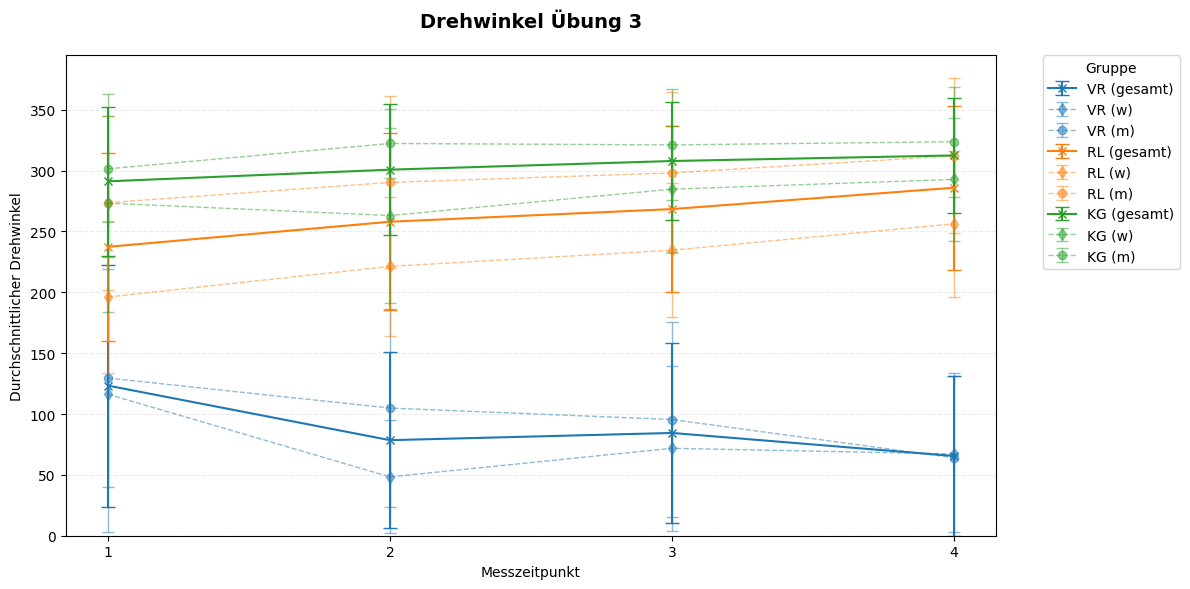

---------------------- Mean_Catch ----------------------
VR (gesamt)
#Teilnehmer gesamt: 30
Messzeitpunkt 1: 0.481 +- 0.246
Messzeitpunkt 4: 0.594 +- 0.226
VR (w)
#Teilnehmer w: 14
Messzeitpunkt 1: 0.381 +- 0.271
Messzeitpunkt 4: 0.535 +- 0.266
VR (m)
#Teilnehmer m: 16
Messzeitpunkt 1: 0.569 +- 0.189
Messzeitpunkt 4: 0.646 +- 0.176
RL (gesamt)
#Teilnehmer gesamt: 47
Messzeitpunkt 1: 0.767 +- 0.221
Messzeitpunkt 4: 0.931 +- 0.116
RL (w)
#Teilnehmer w: 22
Messzeitpunkt 1: 0.734 +- 0.256
Messzeitpunkt 4: 0.892 +- 0.129
RL (m)
#Teilnehmer m: 25
Messzeitpunkt 1: 0.795 +- 0.184
Messzeitpunkt 4: 0.965 +- 0.092
KG (gesamt)
#Teilnehmer gesamt: 11
Messzeitpunkt 1: 0.717 +- 0.158
Messzeitpunkt 4: 0.837 +- 0.212
KG (w)
#Teilnehmer w: 4
Messzeitpunkt 1: 0.661 +- 0.103
Messzeitpunkt 4: 0.636 +- 0.24
KG (m)
#Teilnehmer m: 7
Messzeitpunkt 1: 0.749 +- 0.181
Messzeitpunkt 4: 0.952 +- 0.059


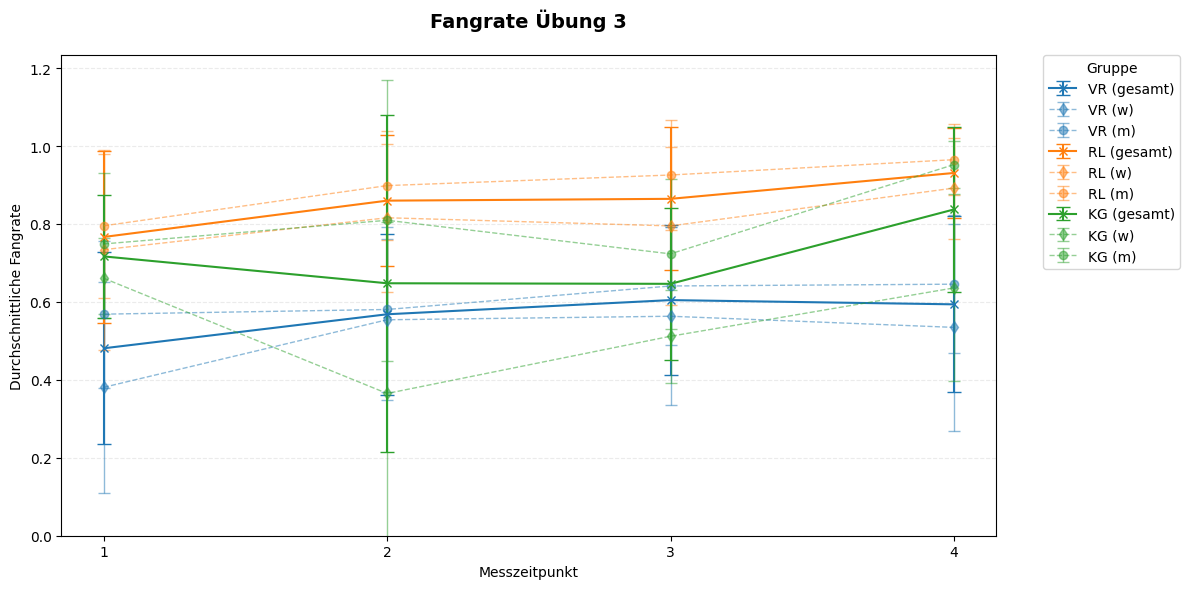

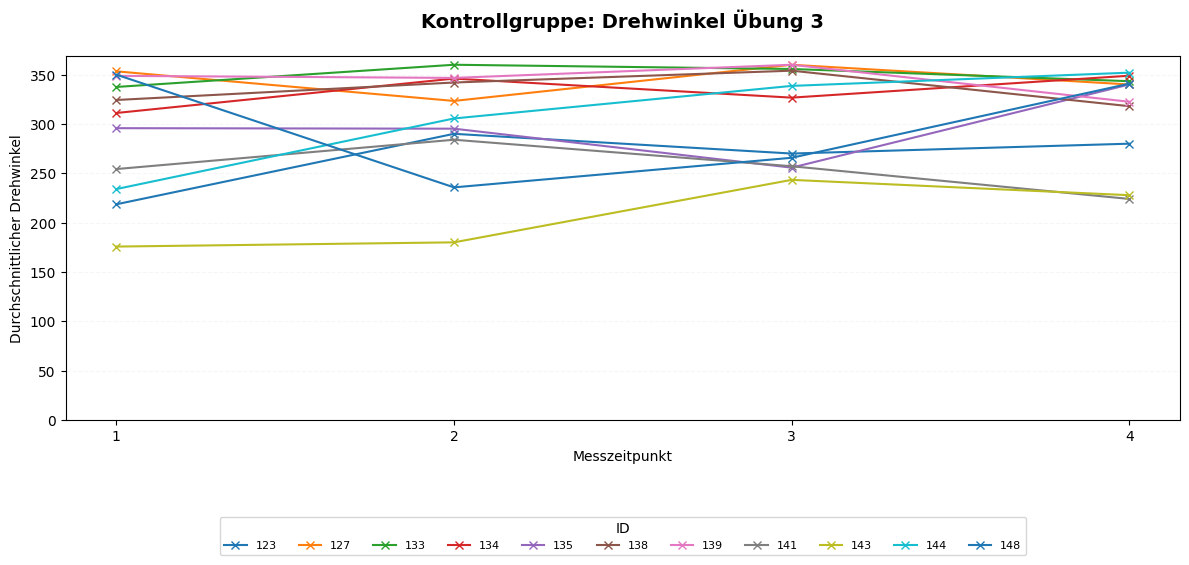

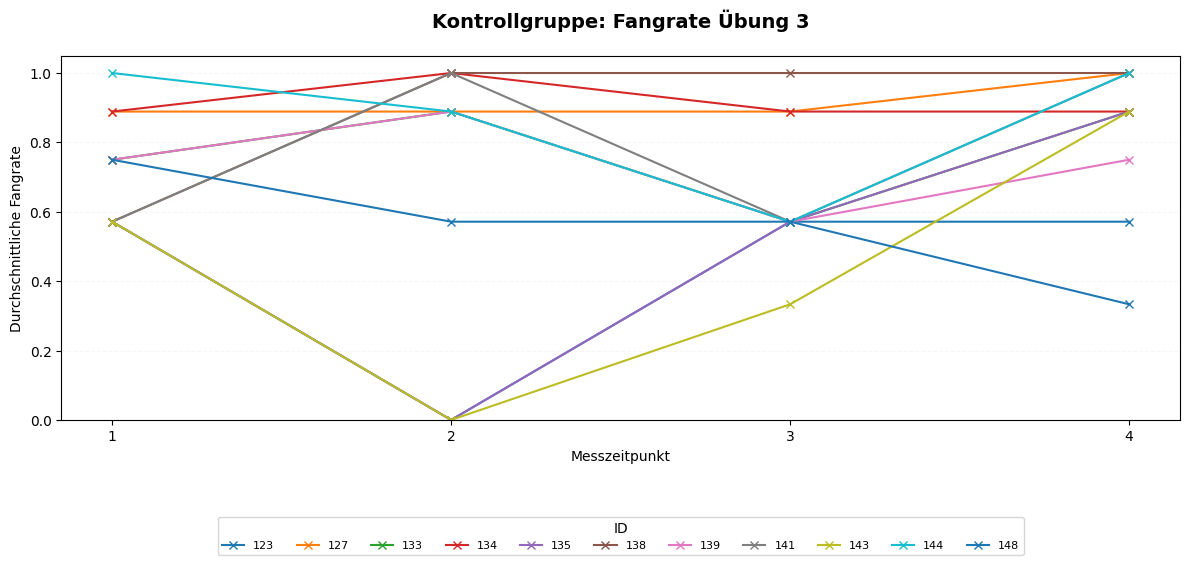

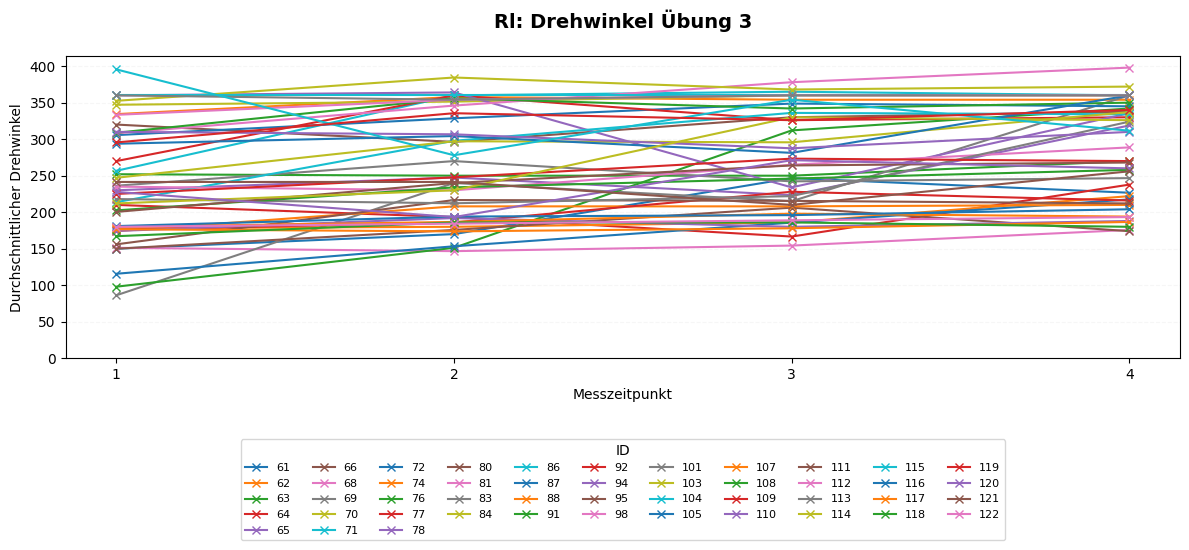

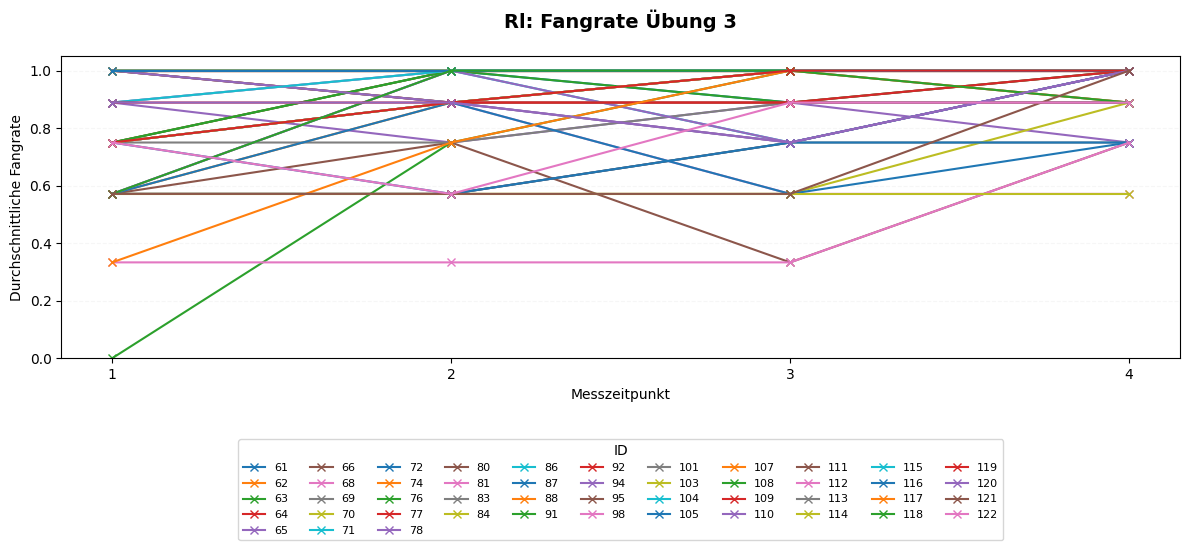

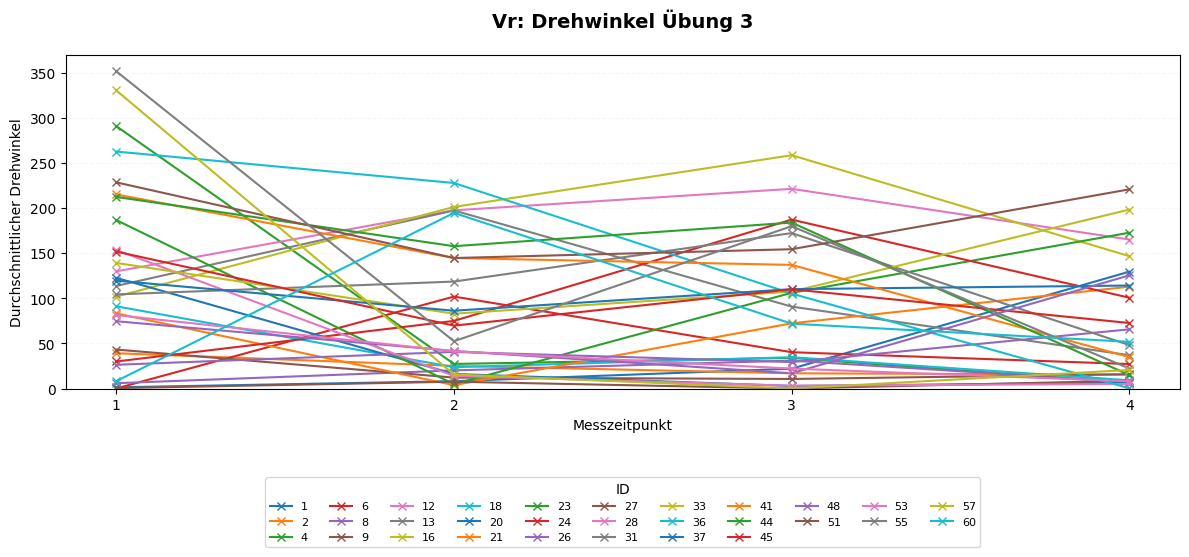

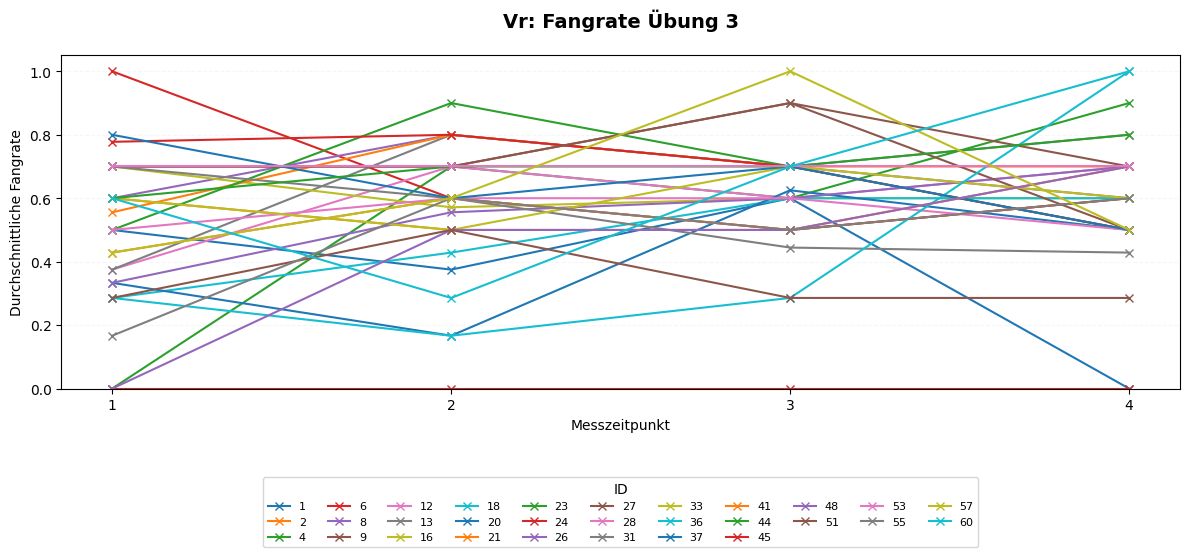

=== Direction Counts with Totals ===
Direction       gerade  hinten  links  rechts  vorne  Summe
Group                                                      
RL                 505     514    208     244    208   1679
VR                 663      23     31       6    372   1095
kontrollgruppe      55     137     25     101     37    355
Summe             1223     674    264     351    617   3129

=== Turn Direction Counts with Totals ===
Turn Direction  links  rechts  rechts   Summe
Group                                        
RL                937     742        0   1679
VR                430     665        0   1095
kontrollgruppe    290      64        1    355
Summe            1657    1471        1   3129


In [10]:
configuration = "valid_catched_False"
df = pd.read_csv(f"data/Exercise_3_{configuration}.csv")
groups = ["kontrollgruppe", "RL 7e", "RL 7f", "VR"]

# Load gender data: ID, gender
df_gender = pd.read_csv("data/gender.csv")
# add gender to the df
df = pd.merge(df, df_gender, on="ID", how="left")

plot_improvement_over_time(df.copy())
plot_results_per_ID_within_group(df.copy())
print_meta_info(df, configuration)